I will be predicting employee attrition (whether an employee will quit or not) based on 33 variables:
 `Age`,
 `BusinessTravel`,
 `DailyRate`,
 `Department`,
 `DistanceFromHome`,
 `Education`,
 `EducationField`,
 `EmployeeCount`,
 `EnvironmentSatisfaction`,
 `Gender`,
 `HourlyRate`,
 `JobInvolvement`,
 `JobLevel`,
 `JobRole`,
 `JobSatisfaction`,
 `MaritalStatus`,
 `MonthlyIncome`,
 `MonthlyRate`,
 `NumCompaniesWorked`,
 `Over18`,
 `OverTime`,
 `PercentSalaryHike`,
 `PerformanceRating`,
 `RelationshipSatisfaction`,
 `StandardHours`,
 `StockOptionLevel`,
 `TotalWorkingYears`,
 `TrainingTimesLastYear`,
 `WorkLifeBalance`,
 `YearsAtCompany`,
 `YearsInCurrentRole`,
 `YearsSinceLastPromotion`,
 `YearsWithCurrManager`.

Plus `id`, which is not interesting for us (only if we want to check our test dataset for data leaks) & `Attrition` -- our target

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

Let's begin by taking a look at the data.

In [2]:
# Load the dataset
train_df = pd.read_csv("data.csv")

In [3]:
train_df.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [4]:
train_df.shape

(1677, 35)

Now for the big question -- do we have any NAs?

And the answer is no!

In [5]:
train_df.isna().sum()

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

Let's define the features for our model to use for training.

In [6]:
train_df.columns

Index(['id', 'Age', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition'],
      dtype='object')

In [7]:
features = list(train_df.columns)
features.remove('id')
features.remove('Attrition')

target = 'Attrition'

Since we have multiple columns with strings, let's encode them as integers. We can use this bit of code below to make our life easier:

In [8]:
# source: https://stackoverflow.com/a/30267328/1105837

class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns  # array of column names to encode

    def fit(self, X, y=None):
        return self  # not relevant here

    def transform(self, X):
        """
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        """
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

Here are the string columns we will be encoding as integers.

In [9]:
columns_with_strings_as_values = list((train_df.dtypes[train_df.dtypes == 'object']).index)
columns_with_strings_as_values

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [10]:
label_encoder = MultiColumnLabelEncoder(columns=columns_with_strings_as_values)
train_df = label_encoder.fit_transform(train_df)

In [11]:
# Split features and target variable
X = train_df[features]
y = train_df[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Initialize and train the classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [13]:
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best classifier from the grid search
best_clf = grid_search.best_estimator_

# Make predictions
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8174424034869241


Let us now look at the variables that are important according to our model.

In [14]:
feature_importances = best_clf.feature_importances_
feature_names = np.array(features)

# Получаем отсортированные индексы признаков (в порядке убывания важности)
indices = feature_importances.argsort()[::-1]

# Нормализуем важность признаков
normalized_importances = feature_importances[indices] / feature_importances.sum()

In [15]:
pd.DataFrame(feature_importances[indices], index=feature_names[indices])

,0
MonthlyIncome,0.084195
MonthlyRate,0.060729
Age,0.058212
StockOptionLevel,0.056327
DailyRate,0.053630
YearsAtCompany,0.052526
TotalWorkingYears,0.050415
HourlyRate,0.049994
DistanceFromHome,0.042873
PercentSalaryHike,0.042593


In [16]:
feature_importances.sum()

1.0

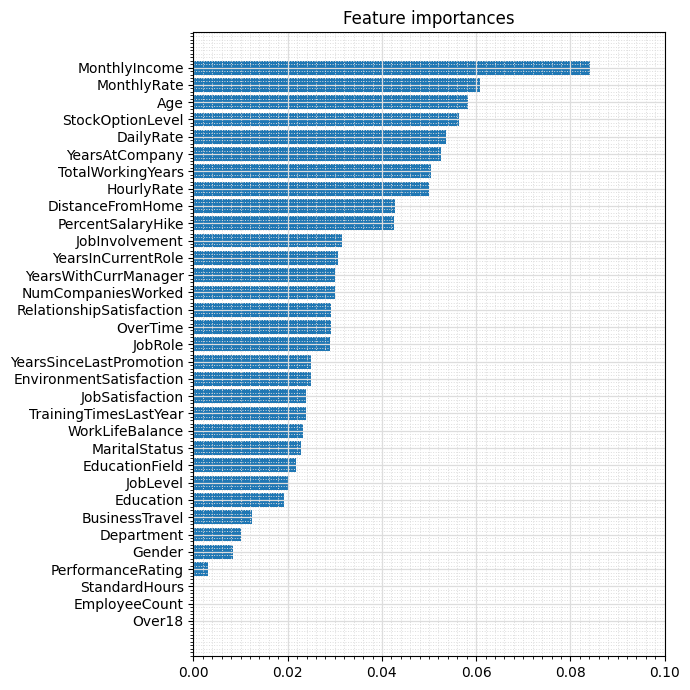

In [17]:
# Создаем горизонтальную столбчатую диаграмму
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)

plt.barh(range(len(indices)), normalized_importances, align='center')

ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(10))

ax.set_xlim([0., .1])

plt.yticks(range(len(indices)), feature_names[indices])  # Метки по оси y
plt.title('Feature importances')

plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы самые важные были сверху
plt.tight_layout()  # Автоматически подгоняет параметры поддиапазона
plt.show()

These are very interesting findings! Turns out how much you pay your employees actually matters! But it seems that the age of the employee and commute also play a significant role!

F. Belous - SpB. 2024